# Traveling Salesman Problem

## Parameters
- 𝒩 = {0,1,...,𝑛−1}: set of nodes to visit  
- For ease of coding:  
  - 𝒜 = {(𝑖,𝑗) | 𝑖,𝑗 ∈ 𝒩, 𝑖 ≠ 𝑗}: set of arcs  
  - 𝑐𝑖𝑗: distance across arc (𝑖,𝑗) ∈ 𝒜  

## Decision Variables
- 𝑥𝑖𝑗 ∈ {0,1}: =1 iff arc (𝑖,𝑗) ∈ 𝒜 is traversed  
- 𝑢𝑖 ∈ [1, 𝑛−1]: the order in which node 𝑖 ∈ {1, 2, ..., 𝑛−1} is visited  

## Model

**Objective:**  
minimize  
$$
\sum_{(i,j) \in \mathcal{A}} c_{ij} x_{ij}
$$  
*Minimize total distance*

**Subject to:**

$$
\sum_{j: (j,i) \in \mathcal{A}} x_{ji} = 1, \quad \forall i \in \mathcal{N}
$$  
*Each city visited exactly once*

$$
\sum_{j: (i,j) \in \mathcal{A}} x_{ij} = 1, \quad \forall i \in \mathcal{N}
$$

**Subtour Elimination Constraints:**

$$
u_j \ge u_i + 1 - n(1 - x_{ij}), \quad \forall i, j \in \{1, 2, ..., n-1\}
$$

**Variable Domains:**

$$
x_{ij} \in \{0,1\}, \quad \forall (i,j) \in \mathcal{A}
$$

$$
1 \le u


Restricted license - for non-production use only - expires 2026-11-23
Set parameter TimeLimit to value 30
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-1360P, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
TimeLimit  30

Optimize a model with 401 rows, 420 columns and 1845 nonzeros
Model fingerprint: 0xd0037a22
Variable types: 20 continuous, 400 integer (400 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [3e+00, 1e+02]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 2e+01]
Presolve removed 19 rows and 21 columns
Presolve time: 0.03s
Presolved: 382 rows, 399 columns, 1786 nonzeros
Variable types: 19 continuous, 380 integer (380 binary)
Found heuristic solution: objective 1007.6707221

Root relaxation: objective 3.006900e+02, 61 iterations, 0.00 seconds (0.00 work units)

 

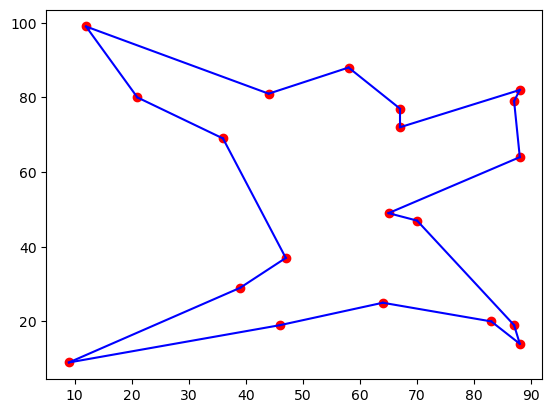

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp

# ----- data -----
# number of customers
n = 20

# generate locations
np.random.seed(0)
loc_x = np.random.randint(0, 100, n)
loc_y = np.random.randint(0, 100, n)

# calculate distance
d = {
    (i, j): ((loc_x[i] - loc_x[j]) ** 2 + (loc_y[i] - loc_y[j]) ** 2) ** 0.5
    for i in range(n)
    for j in range(n)
}

# ----- model -----
m = gp.Model("tsp")

# decision variable
x = m.addVars(n, n, vtype=gp.GRB.BINARY, name="x")
for i in range(n):
    x[i, i].UB = 0  # no self-loop

# objective
m.setObjective(
    gp.quicksum(x[i, j] * d[i, j] for i in range(n) for j in range(n)), gp.GRB.MINIMIZE
)

# constraints
# flow conservation
m.addConstrs(
    (gp.quicksum(x[j, i] for j in range(n)) == 1 for i in range(n)), name="inflow"
)
m.addConstrs(
    (gp.quicksum(x[i, j] for j in range(n)) == 1 for i in range(n)), name="outflow"
)

# subtour elimination (MTZ，Miller-Tucker-Zemlin)
u = m.addVars(n, lb=1, ub=n - 1, name="u")
m.addConstrs(
    (
        u[j] >= u[i] + 1 - n * (1 - x[i, j])
        for i in rangMiller - Tucker - Zemline(1, n)
        for j in range(1, n)
    ),
    name="mtz",
)

# optimize
m.params.timelimit = 30
m.optimize()

# print
print("The solution time is", m.runtime)
print("The MIP gap is", m.mipgap)
print("The known bound is", m.objbound)

# ----- visualize results -----
if m.status != gp.GRB.INFEASIBLE:
    # get results
    selected = [(i, j) for i in range(n) for j in range(n) if x[i, j].x > 0.9]

    # plot results
    plt.scatter(loc_x, loc_y, c="r", marker="o")
    for i, j in selected:
        plt.plot((loc_x[i], loc_x[j]), (loc_y[i], loc_y[j]), c="b")
    plt.savefig("tour.png", dpi=300)
    plt.show()

# Capacitated Vehicle Routing Problem (CVRP)

## Problem Statement
What is the optimal set of routes for a fleet of vehicles to traverse in order to deliver to a given set of customers **with least cost**?

---

## Parameters

### Node Parameters
- \( n \): Number of customers  
- \( \mathcal{N}_C = \{1, 2, \ldots, n\} \): Set of customer nodes  
- \( \mathcal{N} = \mathcal{N}_C \cup \{0\} \): Set of all nodes, including depot  
- \( 0 \in \mathcal{N} \): Depot node  
- \( q_i \): Demand of customer \( i \in \mathcal{N}_C \)

### Arc Parameters
- \( \mathcal{A} = \{(i, j): i, j \in \mathcal{N}, i \ne j\} \): Set of directed arcs  
- \( c_{ij} \): Cost associated with arc \( (i, j) \in \mathcal{A} \)  
    - Examples: distance, time, money

### Vehicle Parameters
- \( m \): Number of available vehicles  
- \( Q \): Capacity of each vehicle (assumed homogeneous)

---

## Decision Variables
- \( x_{ij} \in \{0, 1\} \):  
    \( = 1 \) if arc \( (i, j) \) is traversed by some vehicle, 0 otherwise  
- \( u_i \in [q_i, Q] \):  
    Load of the vehicle after visiting customer \( i \in \mathcal{N}_C \)

---

## Mathematical Model

\[
\begin{align*}
\min\ & \sum_{(i,j) \in \mathcal{A}} c_{ij} x_{ij} \\
\text{s.t.}\quad
& \sum_{j \in \mathcal{N}, (i,j) \in \mathcal{A}} x_{ij} = 1,\quad \forall i \in \mathcal{N}_C \\
& \sum_{j \in \mathcal{N}, (j,i) \in \mathcal{A}} x_{ji} = 1,\quad \forall i \in \mathcal{N}_C \\
& \sum_{j \in \mathcal{N}, (0,j) \in \mathcal{A}} x_{0j} \le m \\
& u_j - u_i + Q (1 - x_{ij}) \ge q_j,\quad \forall i, j \in \mathcal{N}_C, i \ne j \\
& q_i \le u_i \le Q,\quad \forall i \in \mathcal{N}_C \\
& x_{ij} \in \{0, 1\},\quad \forall (i,j) \in \mathcal{A}
\end{align*}
\]

---

## Notes
- The first two constraints ensure that each customer is visited exactly once.
- The third constraint limits the number of vehicles leaving the depot.
- The fourth constraint is the **subtour elimination constraint**, using **MTZ (Miller-Tucker-Zemlin)** formulation.
- The last constraint ensures load feasibility and binary decisions on arc selection.


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gurobipy as gp

# ----- data -----
# Read city coordinates from cn.csv
df = pd.read_csv(r"d:\Visual Studio Code\Operation Research\cn.csv")
loc_x = df["lng"].values
loc_y = df["lat"].values
n = len(df)

# calculate distance
d = {
    (i, j): ((loc_x[i] - loc_x[j]) ** 2 + (loc_y[i] - loc_y[j]) ** 2) ** 0.5
    for i in range(n)
    for j in range(n)
}

# ----- model -----
m = gp.Model("tsp")

# decision variable
x = m.addVars(n, n, vtype=gp.GRB.BINARY, name="x")
for i in range(n):
    x[i, i].UB = 0  # no self-loop

# objective
m.setObjective(
    gp.quicksum(x[i, j] * d[i, j] for i in range(n) for j in range(n)), gp.GRB.MINIMIZE
)

# constraints
# flow conservation
m.addConstrs(
    (gp.quicksum(x[j, i] for j in range(n)) == 1 for i in range(n)), name="inflow"
)
m.addConstrs(
    (gp.quicksum(x[i, j] for j in range(n)) == 1 for i in range(n)), name="outflow"
)

# subtour elimination (MTZ)
u = m.addVars(n, lb=1, ub=n - 1, name="u")
m.addConstrs(
    (u[j] >= u[i] + 1 - n * (1 - x[i, j]) for i in range(1, n) for j in range(1, n)),
    name="mtz",
)

# optimize
m.params.timelimit = 30
m.optimize()

# print
print("The solution time is", m.runtime)
print("The MIP gap is", m.mipgap)
print("The known bound is", m.objbound)

# ----- visualize results -----
if m.status != gp.GRB.INFEASIBLE:
    selected = [(i, j) for i in range(n) for j in range(n) if x[i, j].x > 0.9]
    plt.figure(figsize=(8, 8))
    plt.scatter(loc_x, loc_y, c="r", marker="o")
    for i, j in selected:
        plt.plot((loc_x[i], loc_x[j]), (loc_y[i], loc_y[j]), c="b")
    for idx, (x0, y0) in enumerate(zip(loc_x, loc_y)):
        plt.text(x0, y0, str(idx), fontsize=9, ha="right")
    plt.title("TSP Solution")
    plt.savefig("tour_cn.jpg", dpi=300)
    plt.show()
else:
    print("No feasible solution found.")

Set parameter TimeLimit to value 30
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-1360P, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
TimeLimit  30



GurobiError: Model too large for size-limited license; visit https://gurobi.com/unrestricted for more information